In [1]:
import sys
import celerite2.jax.terms as jax_terms
import jax.numpy as jnp
import numpy as np
import numpyro
import numpyro.distributions as dist
import matplotlib.pyplot as plt
import jax.numpy as jnp

from mind_the_gaps.gpmodelling import GPModelling, GPModellingComparison
from mind_the_gaps.lightcurves import GappyLightcurve
from mind_the_gaps.models.kernel_spec import (
    KernelParameterSpec,
    KernelSpec,
    KernelTermSpec,
)
from mind_the_gaps.simulator import Simulator
from scipy.stats import percentileofscore
from mind_the_gaps.models.psd_models import BendingPowerlaw, Lorentzian
cpus = 10 



celerite2.jax only works with dtype float64. We're enabling x64 now, but you might run into issues if you've already run some jax code.
You can squash this warning by setting the environment variable 'JAX_ENABLE_X64=True' or by running:
>>> from jax import config
>>> config.update('jax_enable_x64', True)
/Users/connorourke/miniconda3/envs/mind_the_gaps/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Case of No period

# Define parameters for lightcurve simulation

In [2]:
times  = np.arange(0, 1000)
dt = np.diff(times)[0]

mean = 100

#A = (mean * 0.1) ** 2 # variance of the lorentzian
#Q = 80
variance_drw = (mean * 0.1) ** 2  # variance of the DRW (bending powerlaw)
w_bend = 2 * np.pi / 20 # angular frequency of the DRW or Bending Powerlaw

# define the PSD model
psd_model = BendingPowerlaw(variance_drw, w_bend) 

# Simulate lightcurve

/Users/connorourke/miniconda3/envs/mind_the_gaps/lib/python3.11/site-packages/stingray/utils.py:403: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment. All analysis in the light curve will assume Poisson errors. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


Text(0, 0.5, 'Rates (ct/s)')

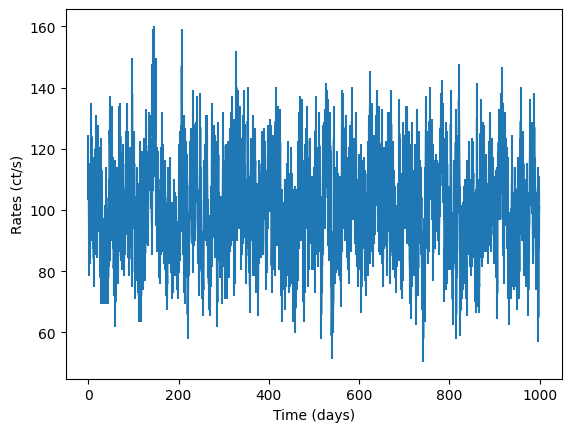

In [3]:
# create simulator object
simulator = Simulator(psd_model, times, np.ones(len(times)) * dt, mean, pdf="Gaussian", 
                     extension_factor=2)
# simulate noiseless count rates from the PSD, make the initial lightcurve 2 times as long as the original times
countrates = simulator.generate_lightcurve()
# add (Poisson) noise
noisy_countrates, dy = simulator.add_noise(countrates)

input_lc = GappyLightcurve(times, noisy_countrates, dy, exposures=dt)

fig = plt.figure()
plt.errorbar(times, noisy_countrates, yerr=dy)
plt.xlabel("Time (days)")
plt.ylabel("Rates (ct/s)")

# Define null hypothesis

Deriving posteriors for null model


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 500 steps.
MCMC not converged after 1000 steps.
MCMC not converged after 1500 steps.
MCMC not converged after 2000 steps.
MCMC not converged after 2500 steps.
MCMC not converged after 3000 steps.
MCMC not converged after 3500 steps.
MCMC converged after 4000 steps.


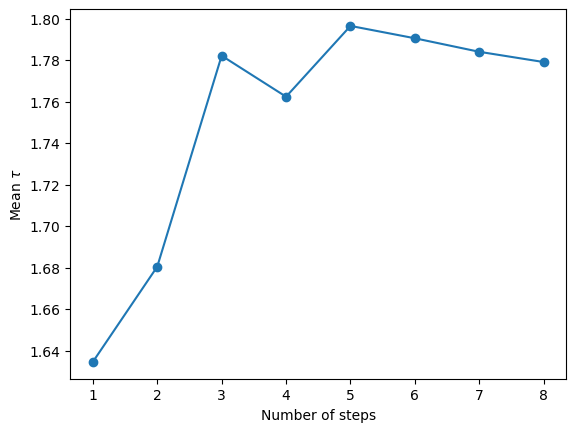

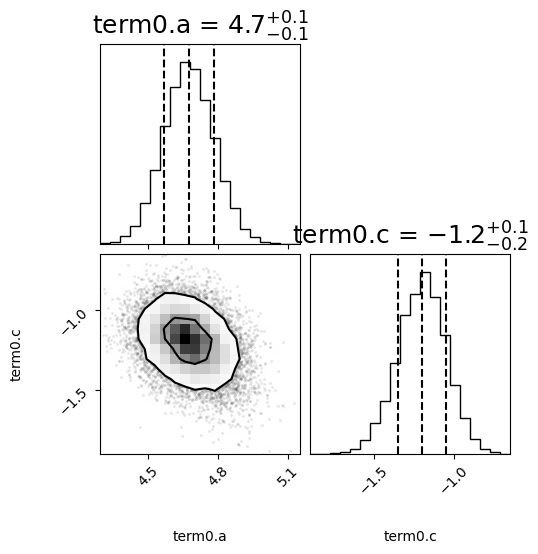

In [4]:
null_kernel_spec = KernelSpec(
        terms=[
            KernelTermSpec(
                term_class=jax_terms.RealTerm,
                parameters={
                    "a": KernelParameterSpec(
                        value=jnp.log(variance_drw),
                        prior=dist.Uniform,
                        bounds=(-10, 150.0),
                    ),
                    "c": KernelParameterSpec(
                        value=jnp.log(w_bend),
                        prior=dist.Uniform,
                        bounds=(-10.0, 10.0),
                    ),
                },
            )
        ],
    )
null_model = GPModelling(kernel_spec=null_kernel_spec,lightcurve=input_lc,meanmodel=None,cpus=cpus,mean_params=jnp.array([input_lc.mean]))
print("Deriving posteriors for null model")
null_model.derive_posteriors(fit=True, max_steps=25000, num_chains=4, num_warmup=1000, converge_steps=500, progress=False)
null_model.plot_autocorrelation()
null_model.corner_plot_samples()


# Define alternative model

log variance of the QPO: 4.61, log_c: -5.54, log omega: -0.46
Deriving posteriors for alternative model


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
sample: 100%|██████████| 1001/1001 [00:45<00:00, 22.03it/s, 31 steps of size 1.03e-01. acc. prob=1.00] 
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc 

MCMC not converged after 500 steps.


sample: 100%|██████████| 500/500 [00:02<00:00, 208.17it/s, 31 steps of size 1.03e-01. acc. prob=0.69] 


MCMC not converged after 1000 steps.


sample: 100%|██████████| 500/500 [00:03<00:00, 164.82it/s, 31 steps of size 1.03e-01. acc. prob=0.72] 


MCMC not converged after 1500 steps.


sample: 100%|██████████| 500/500 [00:03<00:00, 148.98it/s, 143 steps of size 1.03e-01. acc. prob=0.71]


MCMC not converged after 2000 steps.


sample: 100%|██████████| 500/500 [00:03<00:00, 155.36it/s, 43 steps of size 1.03e-01. acc. prob=0.71] 


MCMC not converged after 2500 steps.


sample: 100%|██████████| 500/500 [00:03<00:00, 149.40it/s, 95 steps of size 1.03e-01. acc. prob=0.68] 


MCMC not converged after 3000 steps.


sample: 100%|██████████| 500/500 [00:02<00:00, 214.07it/s, 37 steps of size 1.03e-01. acc. prob=0.67] 


MCMC not converged after 3500 steps.


sample: 100%|██████████| 500/500 [00:02<00:00, 184.36it/s, 7 steps of size 1.03e-01. acc. prob=0.67]  


MCMC not converged after 4000 steps.


sample: 100%|██████████| 500/500 [00:02<00:00, 186.11it/s, 63 steps of size 1.03e-01. acc. prob=0.68] 


MCMC not converged after 4500 steps.


sample: 100%|██████████| 500/500 [00:02<00:00, 200.79it/s, 10 steps of size 1.03e-01. acc. prob=0.68] 


MCMC not converged after 5000 steps.


sample: 100%|██████████| 500/500 [00:03<00:00, 148.73it/s, 7 steps of size 1.03e-01. acc. prob=0.69]  


MCMC not converged after 5500 steps.


sample: 100%|██████████| 500/500 [00:02<00:00, 198.72it/s, 31 steps of size 1.03e-01. acc. prob=0.70]


MCMC not converged after 6000 steps.


sample: 100%|██████████| 500/500 [00:02<00:00, 208.19it/s, 13 steps of size 1.03e-01. acc. prob=0.70] 


MCMC not converged after 6500 steps.


sample: 100%|██████████| 500/500 [00:03<00:00, 141.51it/s, 55 steps of size 1.03e-01. acc. prob=0.71] 


MCMC not converged after 7000 steps.


sample: 100%|██████████| 500/500 [00:02<00:00, 169.17it/s, 23 steps of size 1.03e-01. acc. prob=0.71] 


MCMC not converged after 7500 steps.


sample: 100%|██████████| 500/500 [00:02<00:00, 193.79it/s, 22 steps of size 1.03e-01. acc. prob=0.72]


MCMC not converged after 8000 steps.


sample: 100%|██████████| 500/500 [00:02<00:00, 206.75it/s, 24 steps of size 1.03e-01. acc. prob=0.72] 


MCMC not converged after 8500 steps.


sample: 100%|██████████| 500/500 [00:02<00:00, 224.58it/s, 31 steps of size 1.03e-01. acc. prob=0.72] 


MCMC not converged after 9000 steps.


sample: 100%|██████████| 500/500 [00:02<00:00, 192.95it/s, 31 steps of size 1.03e-01. acc. prob=0.72] 


MCMC not converged after 9500 steps.


sample: 100%|██████████| 500/500 [00:02<00:00, 201.48it/s, 31 steps of size 1.03e-01. acc. prob=0.72] 


MCMC not converged after 10000 steps.


sample: 100%|██████████| 500/500 [00:02<00:00, 194.95it/s, 43 steps of size 1.03e-01. acc. prob=0.72] 


MCMC not converged after 10500 steps.


sample: 100%|██████████| 500/500 [00:03<00:00, 163.17it/s, 15 steps of size 1.03e-01. acc. prob=0.72] 


MCMC not converged after 11000 steps.


sample: 100%|██████████| 500/500 [00:02<00:00, 182.11it/s, 35 steps of size 1.03e-01. acc. prob=0.72] 


MCMC not converged after 11500 steps.


sample: 100%|██████████| 500/500 [00:01<00:00, 362.09it/s, 7 steps of size 1.03e-01. acc. prob=0.70] 


MCMC not converged after 12000 steps.


sample: 100%|██████████| 500/500 [00:02<00:00, 187.02it/s, 48 steps of size 1.03e-01. acc. prob=0.70]


MCMC not converged after 12500 steps.


sample: 100%|██████████| 500/500 [00:02<00:00, 194.16it/s, 31 steps of size 1.03e-01. acc. prob=0.70] 


MCMC not converged after 13000 steps.


sample: 100%|██████████| 500/500 [00:03<00:00, 142.79it/s, 95 steps of size 1.03e-01. acc. prob=0.70] 


MCMC not converged after 13500 steps.


sample: 100%|██████████| 500/500 [00:02<00:00, 224.83it/s, 63 steps of size 1.03e-01. acc. prob=0.70] 


MCMC not converged after 14000 steps.


sample: 100%|██████████| 500/500 [00:02<00:00, 176.67it/s, 95 steps of size 1.03e-01. acc. prob=0.70] 


MCMC not converged after 14500 steps.


sample: 100%|██████████| 500/500 [00:03<00:00, 157.85it/s, 31 steps of size 1.03e-01. acc. prob=0.70] 


MCMC not converged after 15000 steps.


sample: 100%|██████████| 500/500 [00:02<00:00, 179.56it/s, 31 steps of size 1.03e-01. acc. prob=0.71] 


MCMC not converged after 15500 steps.


sample: 100%|██████████| 500/500 [00:02<00:00, 206.85it/s, 15 steps of size 1.03e-01. acc. prob=0.71]


MCMC not converged after 16000 steps.


sample: 100%|██████████| 500/500 [00:02<00:00, 189.14it/s, 29 steps of size 1.03e-01. acc. prob=0.71] 


MCMC not converged after 16500 steps.


sample: 100%|██████████| 500/500 [00:02<00:00, 231.31it/s, 31 steps of size 1.03e-01. acc. prob=0.71]


MCMC not converged after 17000 steps.


sample: 100%|██████████| 500/500 [00:02<00:00, 207.40it/s, 51 steps of size 1.03e-01. acc. prob=0.71] 


MCMC not converged after 17500 steps.


sample: 100%|██████████| 500/500 [00:02<00:00, 185.41it/s, 15 steps of size 1.03e-01. acc. prob=0.71] 


MCMC not converged after 18000 steps.


sample: 100%|██████████| 500/500 [00:02<00:00, 185.96it/s, 31 steps of size 1.03e-01. acc. prob=0.71] 


MCMC not converged after 18500 steps.


sample: 100%|██████████| 500/500 [00:02<00:00, 193.52it/s, 31 steps of size 1.03e-01. acc. prob=0.71] 


MCMC not converged after 19000 steps.


sample: 100%|██████████| 500/500 [00:02<00:00, 176.63it/s, 86 steps of size 1.03e-01. acc. prob=0.71] 


MCMC not converged after 19500 steps.


sample: 100%|██████████| 500/500 [00:02<00:00, 175.57it/s, 31 steps of size 1.03e-01. acc. prob=0.71] 


MCMC not converged after 20000 steps.


sample: 100%|██████████| 500/500 [00:04<00:00, 123.48it/s, 15 steps of size 1.03e-01. acc. prob=0.71] 


MCMC not converged after 20500 steps.


sample: 100%|██████████| 500/500 [00:02<00:00, 199.50it/s, 63 steps of size 1.03e-01. acc. prob=0.71] 


MCMC not converged after 21000 steps.


sample: 100%|██████████| 500/500 [00:02<00:00, 189.33it/s, 47 steps of size 1.03e-01. acc. prob=0.71] 


MCMC not converged after 21500 steps.


sample: 100%|██████████| 500/500 [00:03<00:00, 144.46it/s, 15 steps of size 1.03e-01. acc. prob=0.71] 


MCMC not converged after 22000 steps.


sample: 100%|██████████| 500/500 [00:02<00:00, 186.37it/s, 31 steps of size 1.03e-01. acc. prob=0.71] 


MCMC not converged after 22500 steps.


sample: 100%|██████████| 500/500 [00:02<00:00, 227.72it/s, 3 steps of size 1.03e-01. acc. prob=0.71]  


MCMC not converged after 23000 steps.


sample: 100%|██████████| 500/500 [00:02<00:00, 192.63it/s, 63 steps of size 1.03e-01. acc. prob=0.71]


MCMC not converged after 23500 steps.


sample: 100%|██████████| 500/500 [00:02<00:00, 234.33it/s, 15 steps of size 1.03e-01. acc. prob=0.70] 


MCMC not converged after 24000 steps.


sample: 100%|██████████| 500/500 [00:02<00:00, 177.17it/s, 31 steps of size 1.03e-01. acc. prob=0.70] 


MCMC not converged after 24500 steps.


sample: 100%|██████████| 500/500 [00:02<00:00, 186.31it/s, 31 steps of size 1.03e-01. acc. prob=0.71] 


MCMC not converged after 25000 steps.


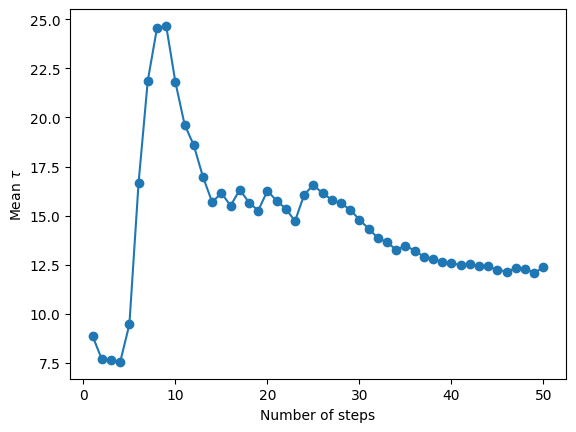

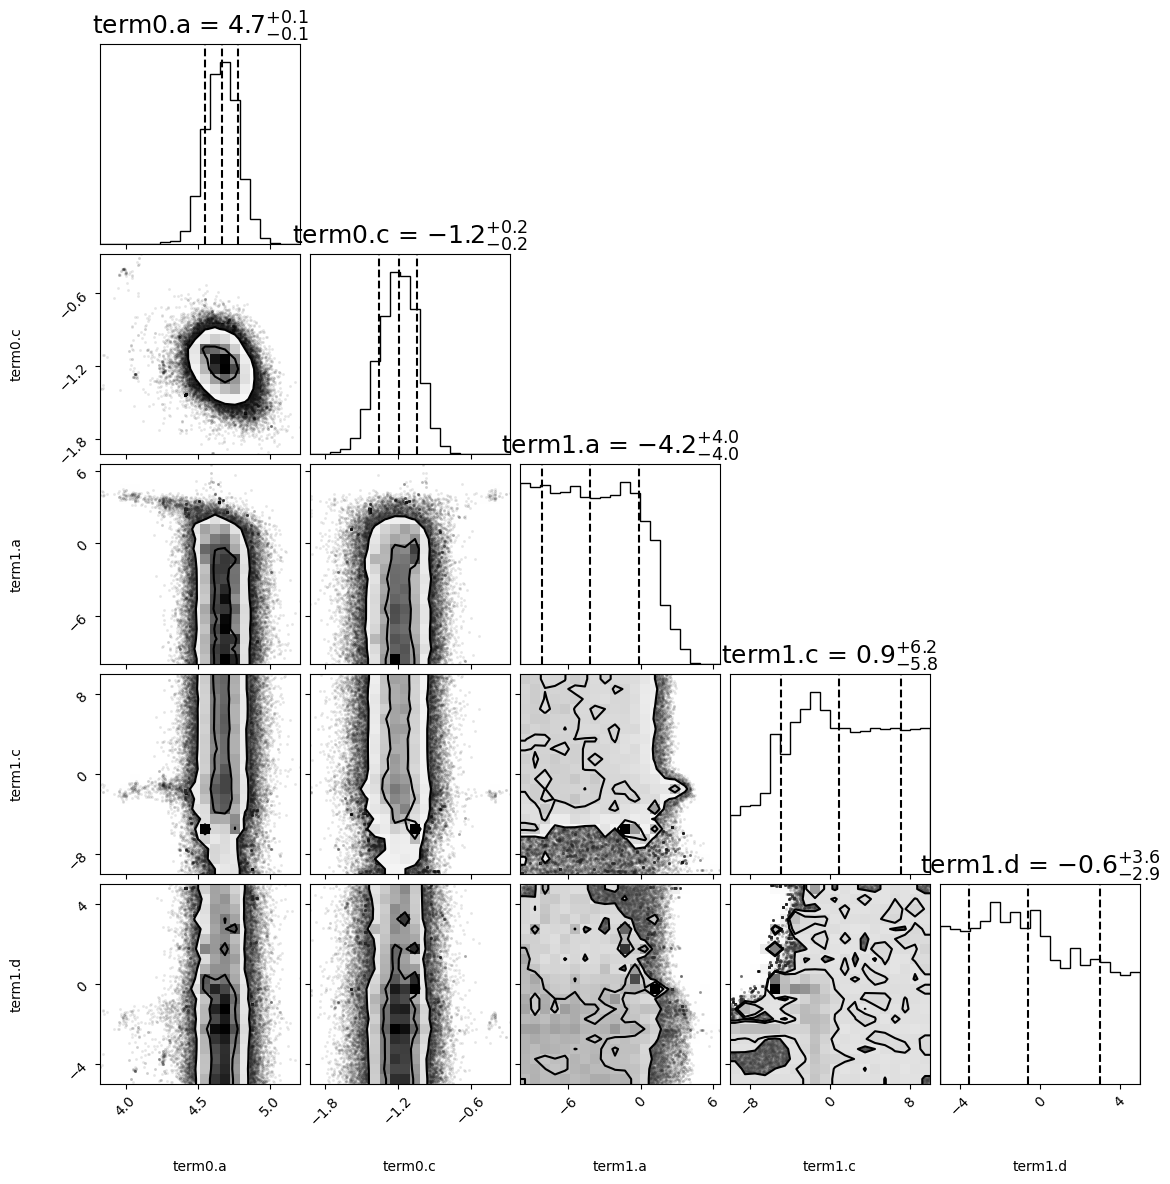

In [7]:
P = 10 # period of the QPO
w = 2 * np.pi / P
# Define starting parameters
log_variance_qpo = np.log(variance_drw)
Q = 80 # coherence
log_c = jnp.log(0.5 * w/Q)
log_d = jnp.log(w)
print(f"log variance of the QPO: {log_variance_qpo:.2f}, log_c: {log_c:.2f}, log omega: {log_d:.2f}")

bounds_qpo = dict(log_a=(-10, 50), log_c=(-10, 10), log_d=(-5, 5))
# You can also use Lorentzian from models.celerite_models (which is defined in terms of variance, Q and omega)
alt_kernel_spec = KernelSpec(
        terms=[
            KernelTermSpec(
                term_class=jax_terms.RealTerm,
                parameters={
                    "a": KernelParameterSpec(
                        value=jnp.log(variance_drw),
                        prior=dist.Uniform,
                        bounds=(-10, 150.0),
                    ),
                    "c": KernelParameterSpec(
                        value=jnp.log(w_bend),
                        prior=dist.Uniform,
                        bounds=(-10.0, 10.0),
                    ),
                },
            ),
            KernelTermSpec(
                term_class=jax_terms.ComplexTerm,
                parameters={
                    "a": KernelParameterSpec(
                        value=log_variance_qpo,
                        prior=dist.Uniform,
                        bounds=(-10, 150.0),
                    ),
                    "c": KernelParameterSpec(
                        value=log_c,
                        prior=dist.Uniform,
                        bounds=(-10, 10.0),
                    ),
                    "d": KernelParameterSpec(
                        value=log_d,
                        prior=dist.Uniform,
                        bounds=(-5.0, 5.0),
                    ),
                    "b": KernelParameterSpec(value=0.0, fixed=True),
                },
            ),
        ],
    )

alternative_model = GPModelling(kernel_spec=alt_kernel_spec,lightcurve=input_lc,meanmodel=None,cpus=cpus,mean_params=jnp.array([input_lc.mean]))
print("Deriving posteriors for alternative model")
alternative_model.derive_posteriors(fit=True, max_steps=25000, num_chains=4, num_warmup=1000, converge_steps=500, progress=True)

alternative_model.plot_autocorrelation()
alternative_model.corner_plot_samples()




# Generate lightcurves from null hypothesis posteriors

In [8]:
nsims = 100 # typically 10,000
lcs = null_model.generate_from_posteriors(nsims=nsims)
print("Done!")

/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:277: UserWarning: The number of simulation requested 100 is higher than the number of posterior samples 4, so many samples will be drawn more than once
  warnings.warn(
/Users/connorourke/miniconda3/envs/mind_the_gaps/lib/python3.11/site-packages/stingray/utils.py:403: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment. All analysis in the light curve will assume Poisson errors. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


Done!


# Fit the lightcurves with both null and alternative models

In [14]:
likelihoods_null = []
likelihoods_alt = []

for i, lc in enumerate(lcs):
    print("Processing lightcurve %d/%d" % (i + 1, len(lcs)), end="\r")
    
    # Run a small MCMC to make sure we find the global maximum of the likelihood
    # ideally we'd probably want to run more samples
    null_modelling = GPModelling(kernel_spec=null_kernel_spec,lightcurve=lc,meanmodel=None,cpus=cpus,mean_params=jnp.array([lc.mean]))
    null_modelling.derive_posteriors(fit=True, max_steps=500, num_chains=4, num_warmup=200, converge_steps=250, progress=False)
    likelihoods_null.append(null_modelling.max_loglikelihood)
    alternative_modelling = GPModelling(kernel_spec=alt_kernel_spec,lightcurve=lc,meanmodel=None,cpus=cpus,mean_params=jnp.array([lc.mean]))
    alternative_modelling.derive_posteriors(fit=True, max_steps=500, num_chains=4, num_warmup=200, converge_steps=250, progress=False)
    likelihoods_alt.append(alternative_modelling.max_loglikelihood)
    
                                                                              
print("\nDone!")

/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.

Done!


# Calculate T_LRT distribution and compare with the observed value

[ 2.44086059  3.81257666  6.61684044  7.1083681   2.99455738  3.16967145
  6.68229321  2.69092257  1.93337142  6.93635413  1.84412692  4.87995687
  2.25668415  2.64843214  6.24176316  9.85445324  5.5621243   4.82414647
  0.15034562  1.55872857  2.87598808  4.04755855  4.52097613  3.21414553
  0.81445629  5.29299269 12.39724029  2.40748568  1.86431112  3.15862933
  5.76996386  8.35275021  3.33945391  4.96914164  2.36768648  1.62833838
  4.35753728  4.28951577  2.36301573  6.15407259  3.90569955  4.77390683
  6.1570613   7.78941195  1.73303949  7.56386126  4.97959769  7.02729938
  0.81323656  4.17481519  2.7387914   4.28371813  1.98858136  2.9887534
  6.51908126  0.69945234  2.855315    1.89164974  1.31177216  1.61694993
  0.89446447  2.82838298  2.03036114  3.25998944  4.4213139   2.12086351
  5.48632812  2.53902734  4.58185061  3.177994    2.30251387  0.61082868
  2.25393407  4.43848901  6.28962172  8.25913     0.63731654  1.8873669
  0.80221475  3.78162991  6.86643588  1.76217148  0.9

Text(0.5, 0, '$T_\\mathrm{LRT}$')

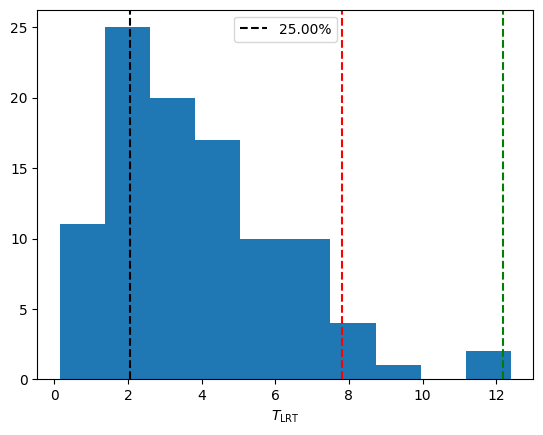

In [17]:
plt.figure()
T_dist = -2 * (np.array(likelihoods_null) - np.array(likelihoods_alt))
print(T_dist)
plt.hist(T_dist, bins=10)
T_obs = -2 * (null_model.max_loglikelihood - alternative_model.max_loglikelihood)
print("Observed LRT_stat: %.3f" % T_obs)
perc = percentileofscore(T_dist, T_obs)
print("p-value: %.4f" % (1 - perc / 100))
plt.axvline(T_obs, label="%.2f%%" % perc, ls="--", color="black")

sigmas = [95, 99.7]
colors= ["red", "green"]
for i, sigma in enumerate(sigmas):
    plt.axvline(np.percentile(T_dist, sigma), ls="--", color=colors[i])
plt.legend()
#plt.axvline(np.percentile(T_dist, 99.97), color="green")
plt.xlabel("$T_\\mathrm{LRT}$")

#plt.savefig("LRT_statistic.png", dpi=100)

We see the p-value to reject the null hypothesis is fairly low, indicating there is no signal in this data, as expected

# Case with Period

# Simulate lightcurve

In [2]:
times  = np.arange(0, 500)
dt = np.diff(times)[0]

mean = 100

P = 10 # period of the QPO
w_qpo = 2 * np.pi / P
w_bend = 2 * np.pi / 20 # angular frequency of the DRW or Bending Powerlaw
# Define starting parameters
variance_drw = (mean * 0.1) ** 2  # variance of the DRW (bending powerlaw)
variance_qpo = variance_drw # let's assume same variance for the QPO and the DRW

Q = 80 # coherence

psd_model = Lorentzian(variance_qpo, Q, w_qpo) + BendingPowerlaw(variance_drw, w_bend) 

/Users/connorourke/miniconda3/envs/mind_the_gaps/lib/python3.11/site-packages/stingray/utils.py:403: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment. All analysis in the light curve will assume Poisson errors. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


Text(0, 0.5, 'Rates (ct/s)')

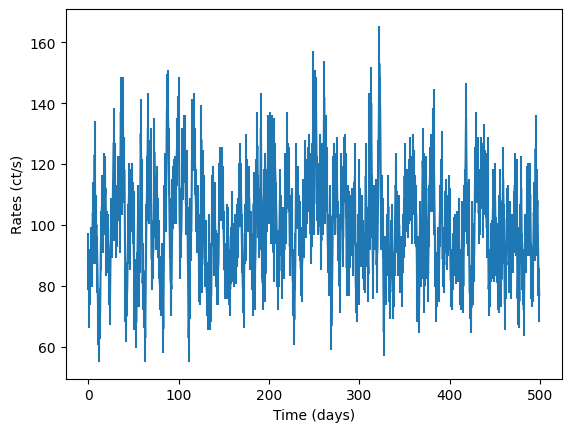

In [4]:
simulator = Simulator(psd_model, times, np.ones(len(times)) * dt, mean, pdf="Gaussian", max_iter=500)

rates = simulator.generate_lightcurve()
noisy_rates, dy = simulator.add_noise(rates)

input_lc = GappyLightcurve(times, noisy_rates, dy, exposures=dt)

fig = plt.figure()
plt.errorbar(times, noisy_rates, yerr=dy)
plt.xlabel("Time (days)")
plt.ylabel("Rates (ct/s)")

# Define null hypothesis

Deriving posteriors for null model


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 500 steps.
MCMC not converged after 1000 steps.
MCMC not converged after 1500 steps.
MCMC not converged after 2000 steps.
MCMC not converged after 2500 steps.
MCMC not converged after 3000 steps.
MCMC converged after 3500 steps.


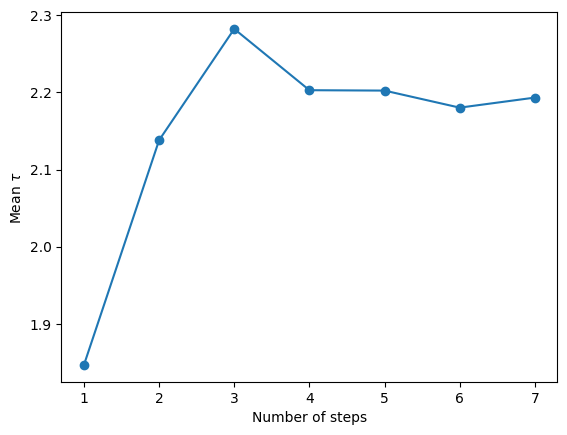

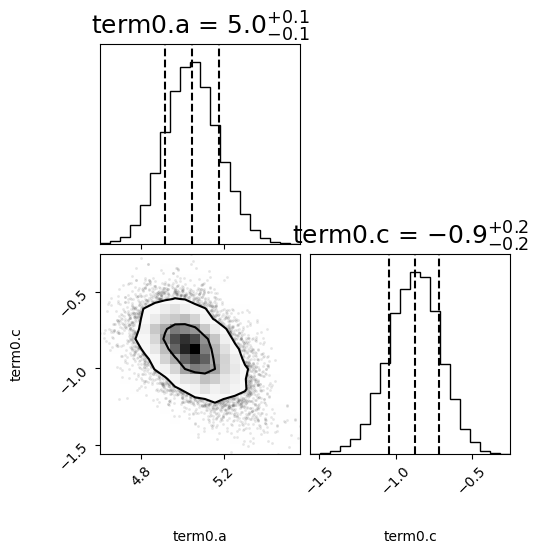

In [5]:

null_kernel_spec =  KernelSpec(
        terms=[
            KernelTermSpec(
                term_class=jax_terms.RealTerm,
                parameters={
                    "a": KernelParameterSpec(
                        value=np.log(variance_drw), 
                        bounds=(-10, 50),
                        prior=dist.Uniform,

                    ),
                    "c": KernelParameterSpec(
                        value=np.log(w_bend), 
                        bounds=(-10, 10),
                        prior=dist.Uniform,
                    ),
                },
            )
        ],
    )
null_model =  GPModelling(kernel_spec=null_kernel_spec,lightcurve=input_lc,meanmodel=None,cpus=cpus,mean_params=jnp.array([input_lc.mean]))
print("Deriving posteriors for null model")
null_model.derive_posteriors(fit=True, max_steps=25000, num_chains=4, num_warmup=1000, converge_steps=500, progress=False)
null_model.plot_autocorrelation()
null_model.corner_plot_samples()


# Define alternative model

Deriving posteriors for alternative model


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 500 steps.
MCMC not converged after 1000 steps.
MCMC not converged after 1500 steps.
MCMC not converged after 2000 steps.
MCMC not converged after 2500 steps.
MCMC not converged after 3000 steps.
MCMC not converged after 3500 steps.
MCMC not converged after 4000 steps.
MCMC not converged after 4500 steps.
MCMC not converged after 5000 steps.
MCMC not converged after 5500 steps.
MCMC not converged after 6000 steps.
MCMC not converged after 6500 steps.
MCMC not converged after 7000 steps.
MCMC not converged after 7500 steps.
MCMC not converged after 8000 steps.
MCMC not converged after 8500 steps.
MCMC not converged after 9000 steps.
MCMC not converged after 9500 steps.
MCMC not converged after 10000 steps.
MCMC not converged after 10500 steps.
MCMC not converged after 11000 steps.
MCMC not converged after 11500 steps.
MCMC not converged after 12000 steps.
MCMC not converged after 12500 steps.
MCMC not converged after 13000 steps.
MCMC not converged after 13500 s

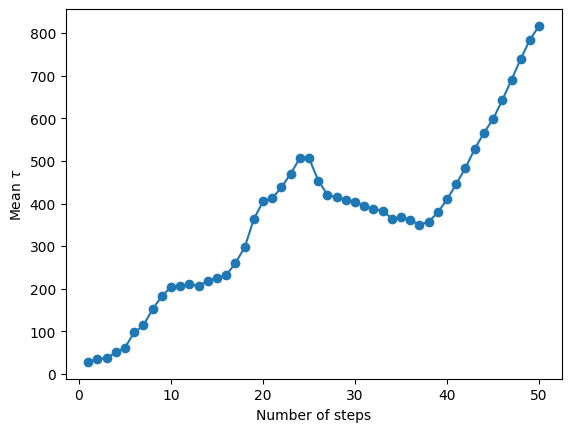

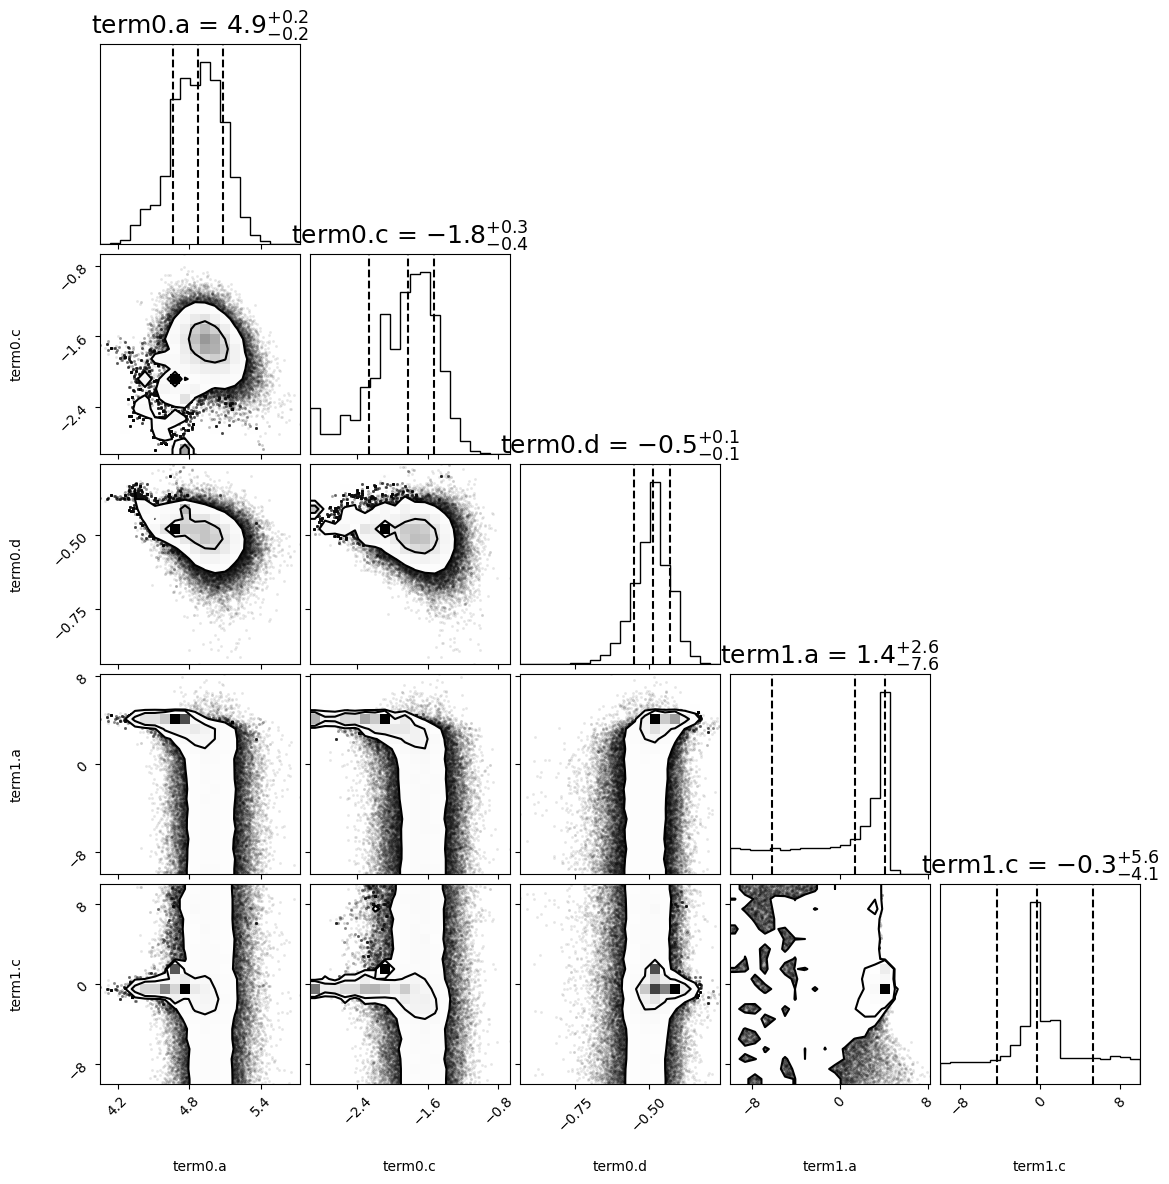

In [6]:
log_c = np.log(0.5 * w_qpo/Q)
log_d = np.log(w_qpo)
bounds_qpo = dict(log_a=(-10, 50), log_c=(-10, 10), log_d=(-5, 5))
# again you may use the Lorentzian from models.celerite_models

alternative_spec = KernelSpec(
        terms=[
            KernelTermSpec(
                term_class=jax_terms.ComplexTerm,
                parameters={
                    "a": KernelParameterSpec(
                        value=np.log(variance_qpo), 
                        bounds=(-10, 150),
                        prior=dist.Uniform
                    ),
                    "c": KernelParameterSpec(value=log_c, 
                                                 bounds=(-10, 50),
                                                 prior=dist.Uniform),
                    "d": KernelParameterSpec(value=log_d, 
                                                 bounds=(-10, 10),
                                                 prior=dist.Uniform),
                    "b": KernelParameterSpec(value=0.0, fixed=True),
                },
            ),
            KernelTermSpec(
                term_class=jax_terms.RealTerm,
                parameters={
                    "a": KernelParameterSpec(
                        value=np.log(variance_drw), 
                        bounds=(-10, 150),
                        prior=dist.Uniform
                    ),
                    "c": KernelParameterSpec(
                        value=np.log(w_bend), 
                        bounds=(-10, 10),
                        prior=dist.Uniform
                    ),
                },
            ),
        ],
    )
alternative_model = GPModelling(kernel_spec=alternative_spec,lightcurve=input_lc,meanmodel=None,cpus=cpus,mean_params=jnp.array([input_lc.mean]))
print("Deriving posteriors for alternative model")
alternative_model.derive_posteriors(fit=True, max_steps=25000, num_chains=4, num_warmup=1000, converge_steps=500, progress=False)

alternative_model.plot_autocorrelation()
alternative_model.corner_plot_samples()



# Generate lightcurves with null hypothesis posteriors

In [7]:
nsims = 100 # typically 10,000
lcs = null_model.generate_from_posteriors(nsims=nsims)
print("Done!")

/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:277: UserWarning: The number of simulation requested 100 is higher than the number of posterior samples 4, so many samples will be drawn more than once
  warnings.warn(
/Users/connorourke/miniconda3/envs/mind_the_gaps/lib/python3.11/site-packages/stingray/utils.py:403: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment. All analysis in the light curve will assume Poisson errors. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


Done!


# Fit the lightcurves with both null and alternative models

In [8]:
likelihoods_null = []
likelihoods_alt = []

for i, lc in enumerate(lcs):
    print("Processing lightcurve %d/%d" % (i + 1, len(lcs)), end="\r")
    
    # Run a small MCMC to make sure we find the global maximum of the likelihood
    # ideally we'd probably want to run more samples
    null_modelling = GPModelling(kernel_spec=null_kernel_spec,lightcurve=lc,meanmodel=None,cpus=cpus,mean_params=jnp.array([lc.mean]))
    null_modelling.derive_posteriors(fit=True, max_steps=500, num_chains=4, num_warmup=200, converge_steps=250, progress=False)
    likelihoods_null.append(null_modelling.max_loglikelihood)
    alternative_modelling = GPModelling(kernel_spec=alternative_spec,lightcurve=lc,meanmodel=None,cpus=cpus,mean_params=jnp.array([lc.mean]))
    alternative_modelling.derive_posteriors(fit=True, max_steps=500, num_chains=4, num_warmup=200, converge_steps=250, progress=False)
    likelihoods_alt.append(alternative_modelling.max_loglikelihood)
    
                                                                              
print("\nDone!")

/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:182: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite2_engine.py:199: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


MCMC not converged after 250 steps.
MCMC not converged after 500 steps.

Done!


# Calculate T_LRT distribution and compare with the observed value

[ 1.68065491e+00  1.02494290e-02  7.06869544e-01  3.16122410e+00
  3.38845823e-01  1.13425915e+00  6.27850974e+00  4.01441207e+00
  2.03671168e-01  1.44597884e+00  3.80823217e-01  4.71613515e-02
  4.00968510e-01  2.19629795e+00  3.85656827e-01  1.17539576e+00
  1.81954479e+00  1.34639595e-01  6.04698424e-01 -5.01966756e-05
  4.43452059e-01  3.16550680e-01  6.98149128e-01  5.71916629e+00
  8.86790277e-02  1.67076861e+00  6.35883517e-01  3.64615121e+00
  3.49963092e+00  4.69329995e-01  1.13339875e+00  3.70629005e-01
  1.87024579e-01  3.38726373e-01  2.95806932e-01 -2.18857075e-04
  1.23194306e+00  1.83324762e+00  7.96592567e-03  3.28052325e+00
  2.70002052e+00  2.21927802e-01 -1.10974197e-02  3.51402031e+00
  5.00162830e-01  3.98623558e-02  1.77766562e+00  2.91268356e+00
  2.95706007e+00  5.66157824e-01  6.98826146e-01  3.64381875e-01
  2.72161688e+00  2.69146462e+00  1.79314678e+00  5.20640222e-01
  3.12763260e-01  1.86691813e-01  3.48700410e-01  1.16007036e+00
 -4.49575496e-03  6.08939

Text(0.5, 0, '$T_\\mathrm{LRT}$')

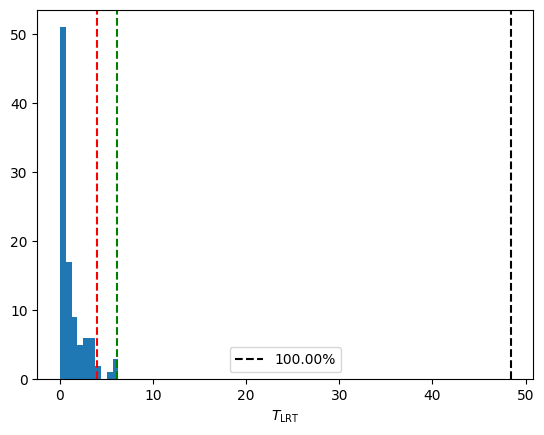

In [9]:
plt.figure()
T_dist = -2 * (np.array(likelihoods_null) - np.array(likelihoods_alt))
print(T_dist)
plt.hist(T_dist, bins=10)
T_obs = -2 * (null_model.max_loglikelihood - alternative_model.max_loglikelihood)
print("Observed LRT_stat: %.3f" % T_obs)
perc = percentileofscore(T_dist, T_obs)
print("p-value: %.4f" % (1 - perc / 100))
plt.axvline(T_obs, label="%.2f%%" % perc, ls="--", color="black")

sigmas = [95, 99.7]
colors= ["red", "green"]
for i, sigma in enumerate(sigmas):
    plt.axvline(np.percentile(T_dist, sigma), ls="--", color=colors[i])
plt.legend()
#plt.axvline(np.percentile(T_dist, 99.97), color="green")
plt.xlabel("$T_\\mathrm{LRT}$")

#plt.savefig("LRT_statistic.png", dpi=100)